In [1]:

import gym
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from tqdm import tqdm
from scipy.optimize import minimize
from IPython.display import display

from mdp_extras import vi, OptimalPolicy, padding_trick, UniformRandomPolicy, PaddedMDPWarning, Linear
from mdp_extras.envs import nchain_extras

from unimodal_irl import sw_maxent_irl, sw_maxent_irl_modelfree, mean_ci, ile_evd, inner_angle


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


In [2]:

n = 5
env = gym.make("NChain-v0", n=n)
xtr, phi, reward_gt = nchain_extras(env, gamma=0.99)

v_star, q_star = vi(xtr, phi, reward_gt)
pi_star = OptimalPolicy(q_star)
max_path_length = 10

num_paths = 1000
demo_star = pi_star.get_rollouts(env, num_paths, max_path_length=max_path_length)
phi_bar = phi.demo_average(demo_star, xtr.gamma)

# Importance sampling policy
pi_ref = UniformRandomPolicy(num_actions=2)


In [3]:

data = []
num_repeats = 100
m_vals = 2 ** np.arange(10 + 1)

for num_sampled_paths in tqdm(m_vals):
    
    for rep in range(num_repeats):
        
        def xp(theta):
            # Run one experiment with a given theta vector
        
            # Find GT values
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore", category=PaddedMDPWarning)
                # Compute ground truth values
                gt_nll, gt_grad = sw_maxent_irl(
                    theta, xtr, phi, phi_bar, max_path_length
                )

            # Get importance sampling dataset
            pi_ref_demos = []
            for _ in range(num_sampled_paths):
                path_len = np.random.randint(1, high=max_path_length + 1)
                path = []
                s = env.reset()
                while len(path) < path_len - 1:
                    a = pi_ref.predict(s)[0]
                    path.append((s, a))
                    s, r, done, _ = env.step(a)
                path.append((s, None))
                pi_ref_demos.append(path)

            nll, grad = sw_maxent_irl_modelfree(
                theta,
                xtr.gamma,
                phi,
                phi_bar,
                max_path_length,
                pi_ref,
                pi_ref_demos,
                nll_only=False
            )
            
            return [
                theta,
                gt_nll,
                gt_grad,
                rep,
                num_sampled_paths,
                nll,
                grad,
                np.abs(gt_nll - nll) / np.abs(gt_nll) * 100,
                inner_angle(gt_grad, grad) / np.pi,
                np.linalg.norm(gt_grad - grad),
            ]
        
        # Randomized theta value
        data.append(["Random"] + xp(np.random.rand(len(phi)) * 20 - 10))
        
        # Zero theta value
        data.append(["Zero"] + xp(np.zeros_like(reward_gt.theta.flat)))
        
        # Ground truth theta value
        data.append(["Ground Truth"] + xp(reward_gt.theta.copy()))

        
df = pd.DataFrame(
    data,
    columns=[
        "Theta Init",
        "Theta",
        "GT NLL",
        "GT NLL Grad",
        "Repeat",
        "M",
        "NLL",
        "NLL Grad",
        "NLL Error (%)",
        "Grad Inner Angle",
        "Grad Error Mag",
    ]
)

display(df.groupby(["Theta Init", "M"]).mean())


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:40<00:00, 14.57s/it]


GT NLL  Repeat        NLL  NLL Error (%)  \
Theta Init   M                                                   
Ground Truth 1     29.882195    49.5  -8.471465     128.349541   
             2     29.882195    49.5  -6.235519     120.867006   
             4     29.882195    49.5  -4.705073     115.745405   
             8     29.882195    49.5  -2.414671     108.080636   
             16    29.882195    49.5   0.531451      98.221512   
             32    29.882195    49.5   2.904813      90.279117   
             64    29.882195    49.5   4.859488      83.737849   
             128   29.882195    49.5   9.442098      68.849803   
             256   29.882195    49.5  12.353371      59.454311   
             512   29.882195    49.5  15.601436      48.314408   
             1024  29.882195    49.5  18.024799      40.195346   
Random       1     47.278023    49.5   5.917749     117.199533   
             2     45.877633    49.5  12.037684      88.647731   
             4     44.678779    49.5  14.863237      92.632143   
             8     43.913662    49.5  19.055429      79.711598   
             16    43.287108    49.5  23.035270      61.380354   
             32    44.952981    49.5  28.084251      47.209501   
             64    44.857147    49.5  29.382429      41.695336   
             128   43.941740    49.5  31.351101      34.485805   
             256   47.318045    49.5  35.686042      27.683385   
             512   43.803666    49.5  32.388562      31.397533   
             1024  43.318393    49.5  35.177542      21.713407   
Zero         1      6.930495    49.5   5.477199      28.846048   
             2      6.930495    49.5   5.935922      21.739199   
             4      6.930495    49.5   6.388862      11.790452   
             8      6.930495    49.5   6.772431       6.937385   
             16     6.930495    49.5   6.907049       4.347487   
             32     6.930495    49.5   6.927107       3.003567   
             64     6.930495    49.5   6.888067       2.324742   
             128    6.930495    49.5   6.908425       1.658033   
             256    6.930495    49.5   6.943725       1.035265   
             512    6.930495    49.5   6.916748       0.673042   
             1024   6.930495    49.5   6.932086       0.484668   

                   Grad Inner Angle  Grad Error Mag  
Theta Init   M                                       
Ground Truth 1             0.470356        5.612515  
             2             0.474315        5.625821  
             4             0.476788        5.851652  
             8             0.461021        5.883070  
             16            0.424830        5.522909  
             32            0.388708        5.083877  
             64            0.359512        4.643167  
             128           0.295291        3.808409  
             256           0.248189        3.159853  
             512           0.208659        2.798121  
             1024          0.176067        2.498734  
Random       1             0.353259        5.586025  
             2             0.313340        4.841402  
             4             0.291516        4.640276  
             8             0.268135        4.332031  
             16            0.257930        4.098610  
             32            0.246503        3.942280  
             64            0.200791        3.396913  
             128           0.202685        3.373080  
             256           0.182493        3.072659  
             512           0.196499        3.238096  
             1024          0.159163        2.646614  
Zero         1             0.166026        1.998325  
             2             0.164273        1.997384  
             4             0.172783        2.090620  
             8             0.171427        1.986118  
             16            0.167310        1.905416  
             32            0.157614        1.713113  
             64            0.153802        1.658031  
             128           0.151744  

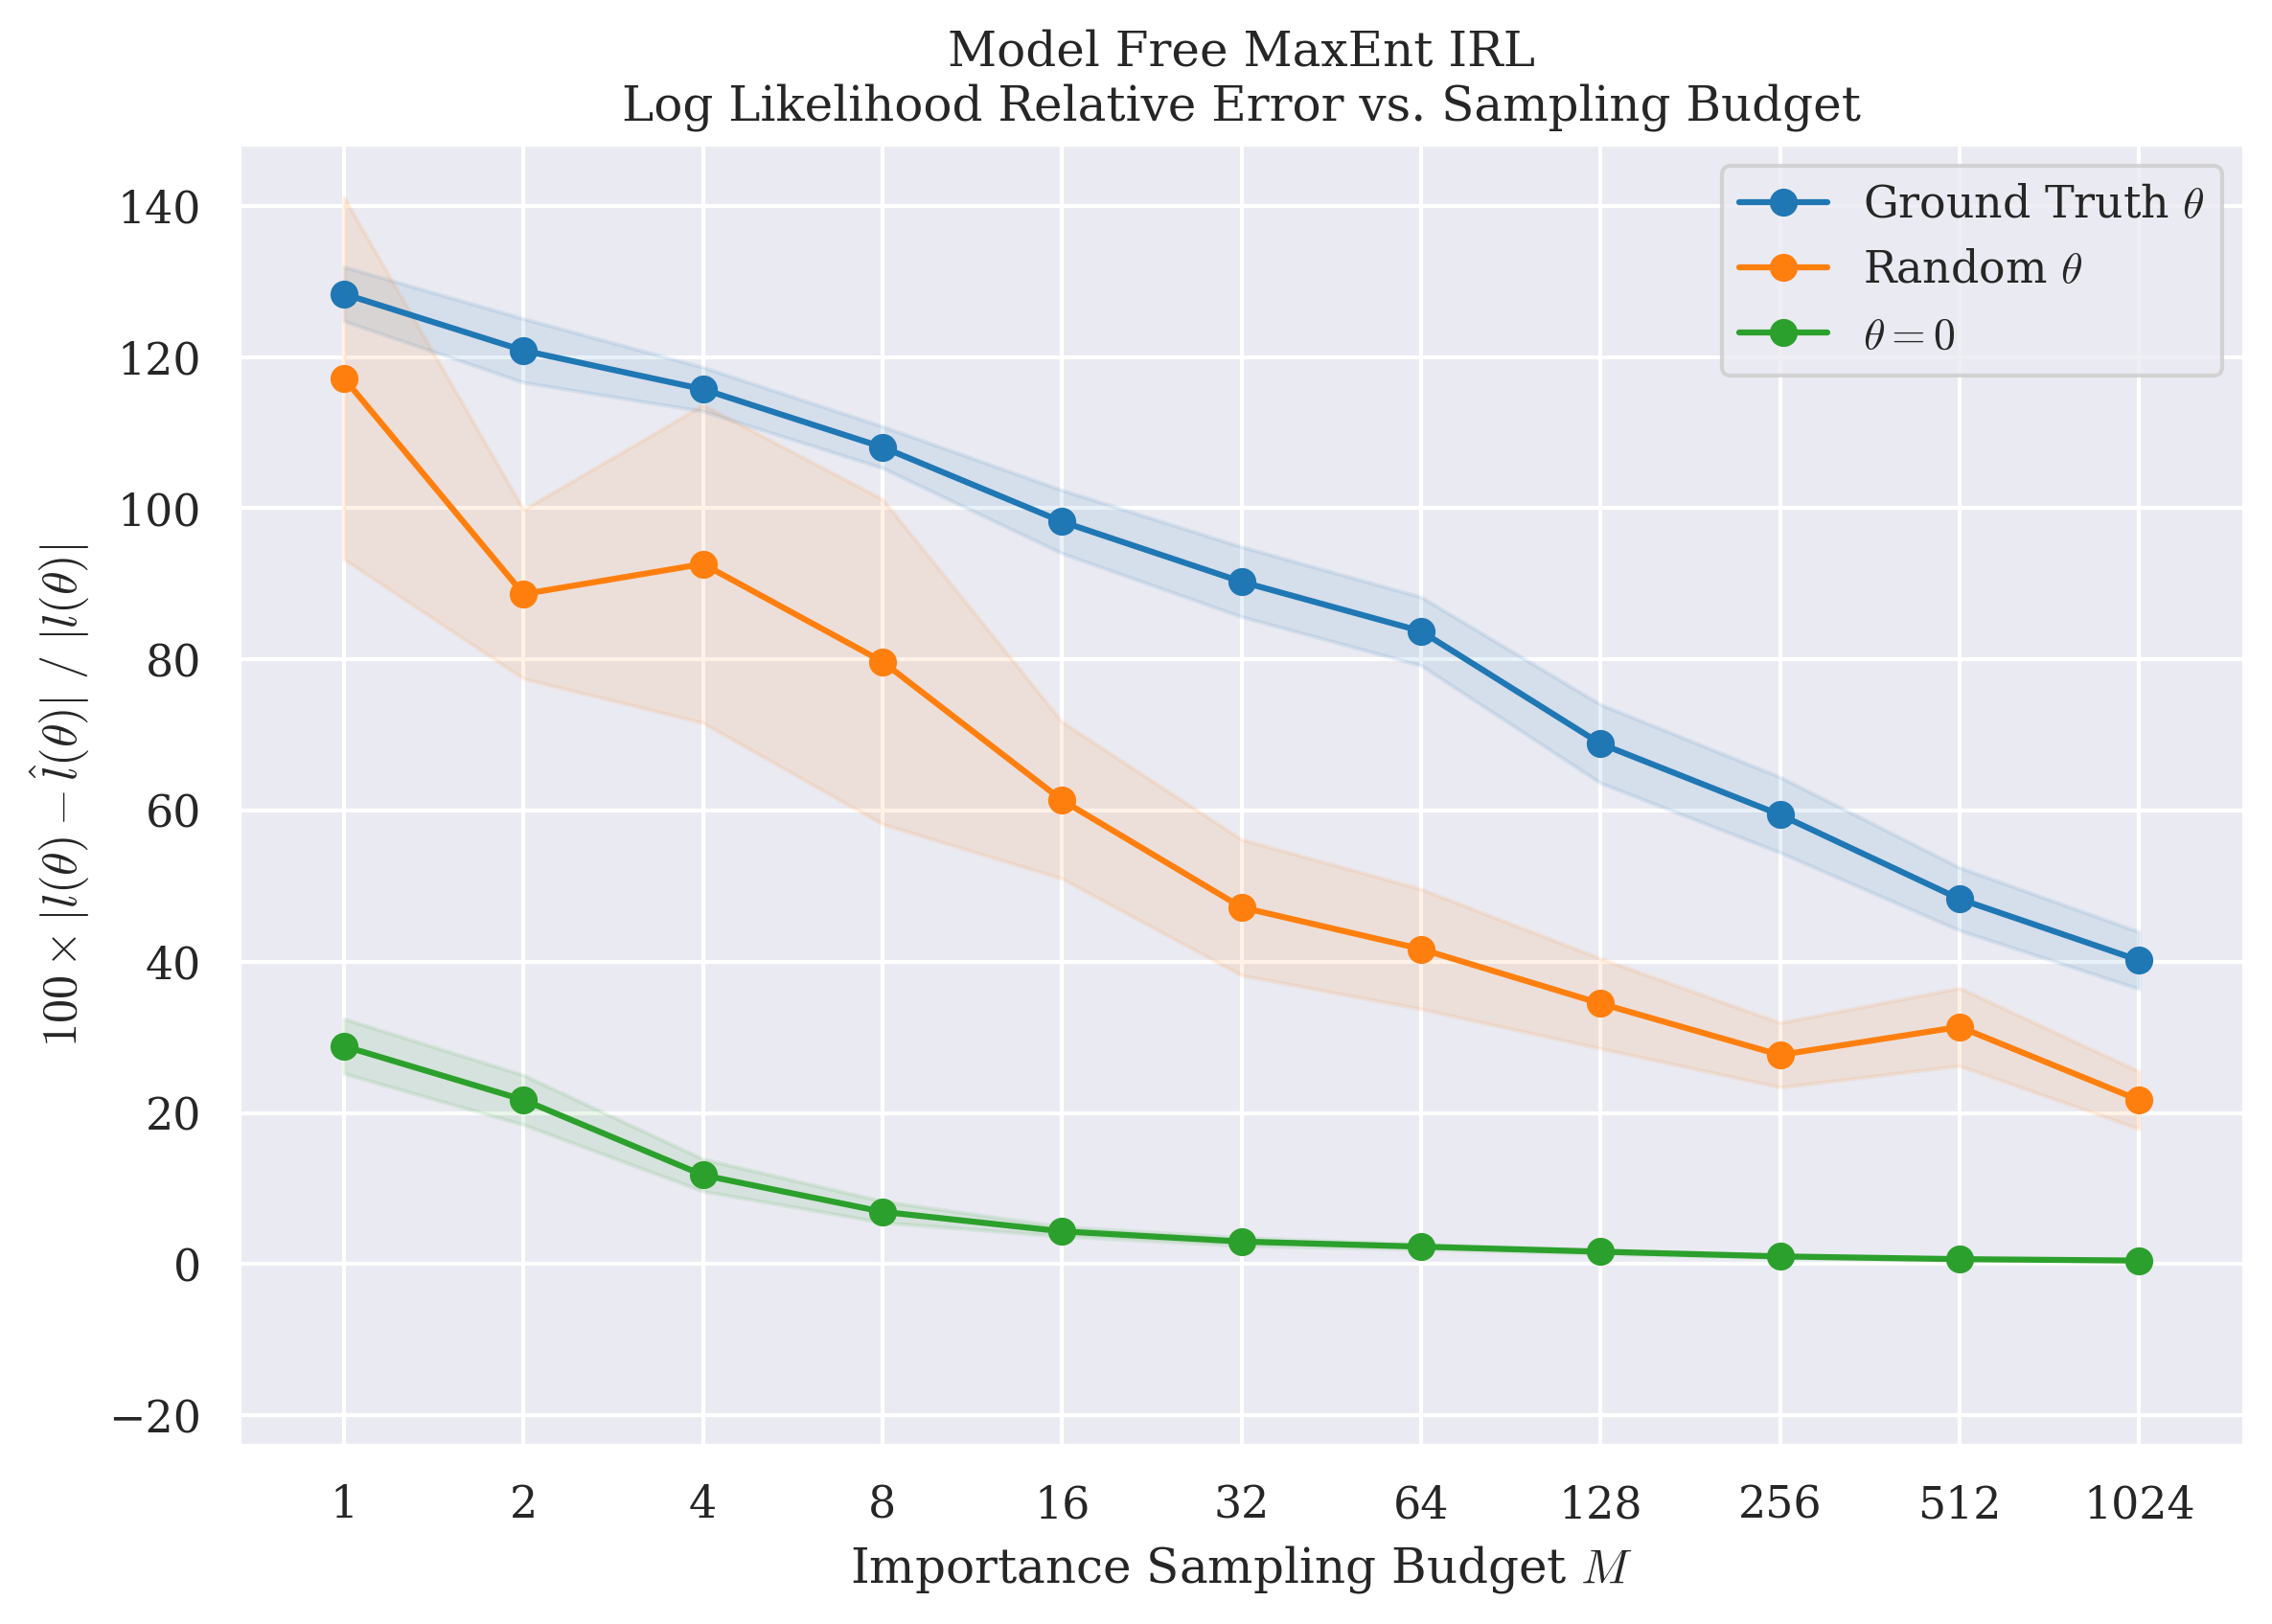

In [4]:

plt.figure(figsize=(9, 6), dpi=300)
sns.set()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams["mathtext.fontset"] = "cm"

def do_plt(col_name, color, label):
    means = []
    cis = []
    for m in m_vals:
        df_slice = df.query(f"`Theta Init` == '{col_name}' and M == {m}")
        _, mean, high = mean_ci(df_slice["NLL Error (%)"].to_numpy())
        means.append(mean)
        cis.append(high - mean)
    means = np.array(means)
    cis = np.array(cis)

    p1 = plt.plot(m_vals, means, 'o-', color=color, label=label)
    plt.fill_between(
        m_vals,
        means - cis,
        means + cis,
        color=p1[0].get_color(),
        alpha=0.1
    )

do_plt("Ground Truth", "tab:blue", r"Ground Truth $\theta$")
do_plt("Random", "tab:orange", r"Random $\theta$")
do_plt("Zero", "tab:green", r"$\theta = 0$")

#plt.ylabel(r"$100 \times \frac{|l(\theta) - \hat{l}(\theta)|}{|l(\theta)|}$")
plt.ylabel(r"$100 \times |l(\theta) - \hat{l}(\theta)| ~/~ |l(\theta)|$")
plt.xlabel(r"Importance Sampling Budget $M$")

plt.semilogx(base=2)
plt.xticks(m_vals, m_vals)

plt.xlim(min(m_vals)/1.5, max(m_vals)*1.5)
top_ylim_space = np.abs(plt.ylim()[1] - 100)
plt.ylim(0 - top_ylim_space / 2, 100 + top_ylim_space)

plt.legend()

plt.savefig("fig-maxent-modelfree-ll-error.pdf", bbox_inches='tight', pad_inches=0)
plt.title("Model Free MaxEnt IRL\nLog Likelihood Relative Error vs. Sampling Budget")
plt.savefig("fig-maxent-modelfree-ll-error-withtitle.pdf", bbox_inches='tight', pad_inches=0)
plt.show()


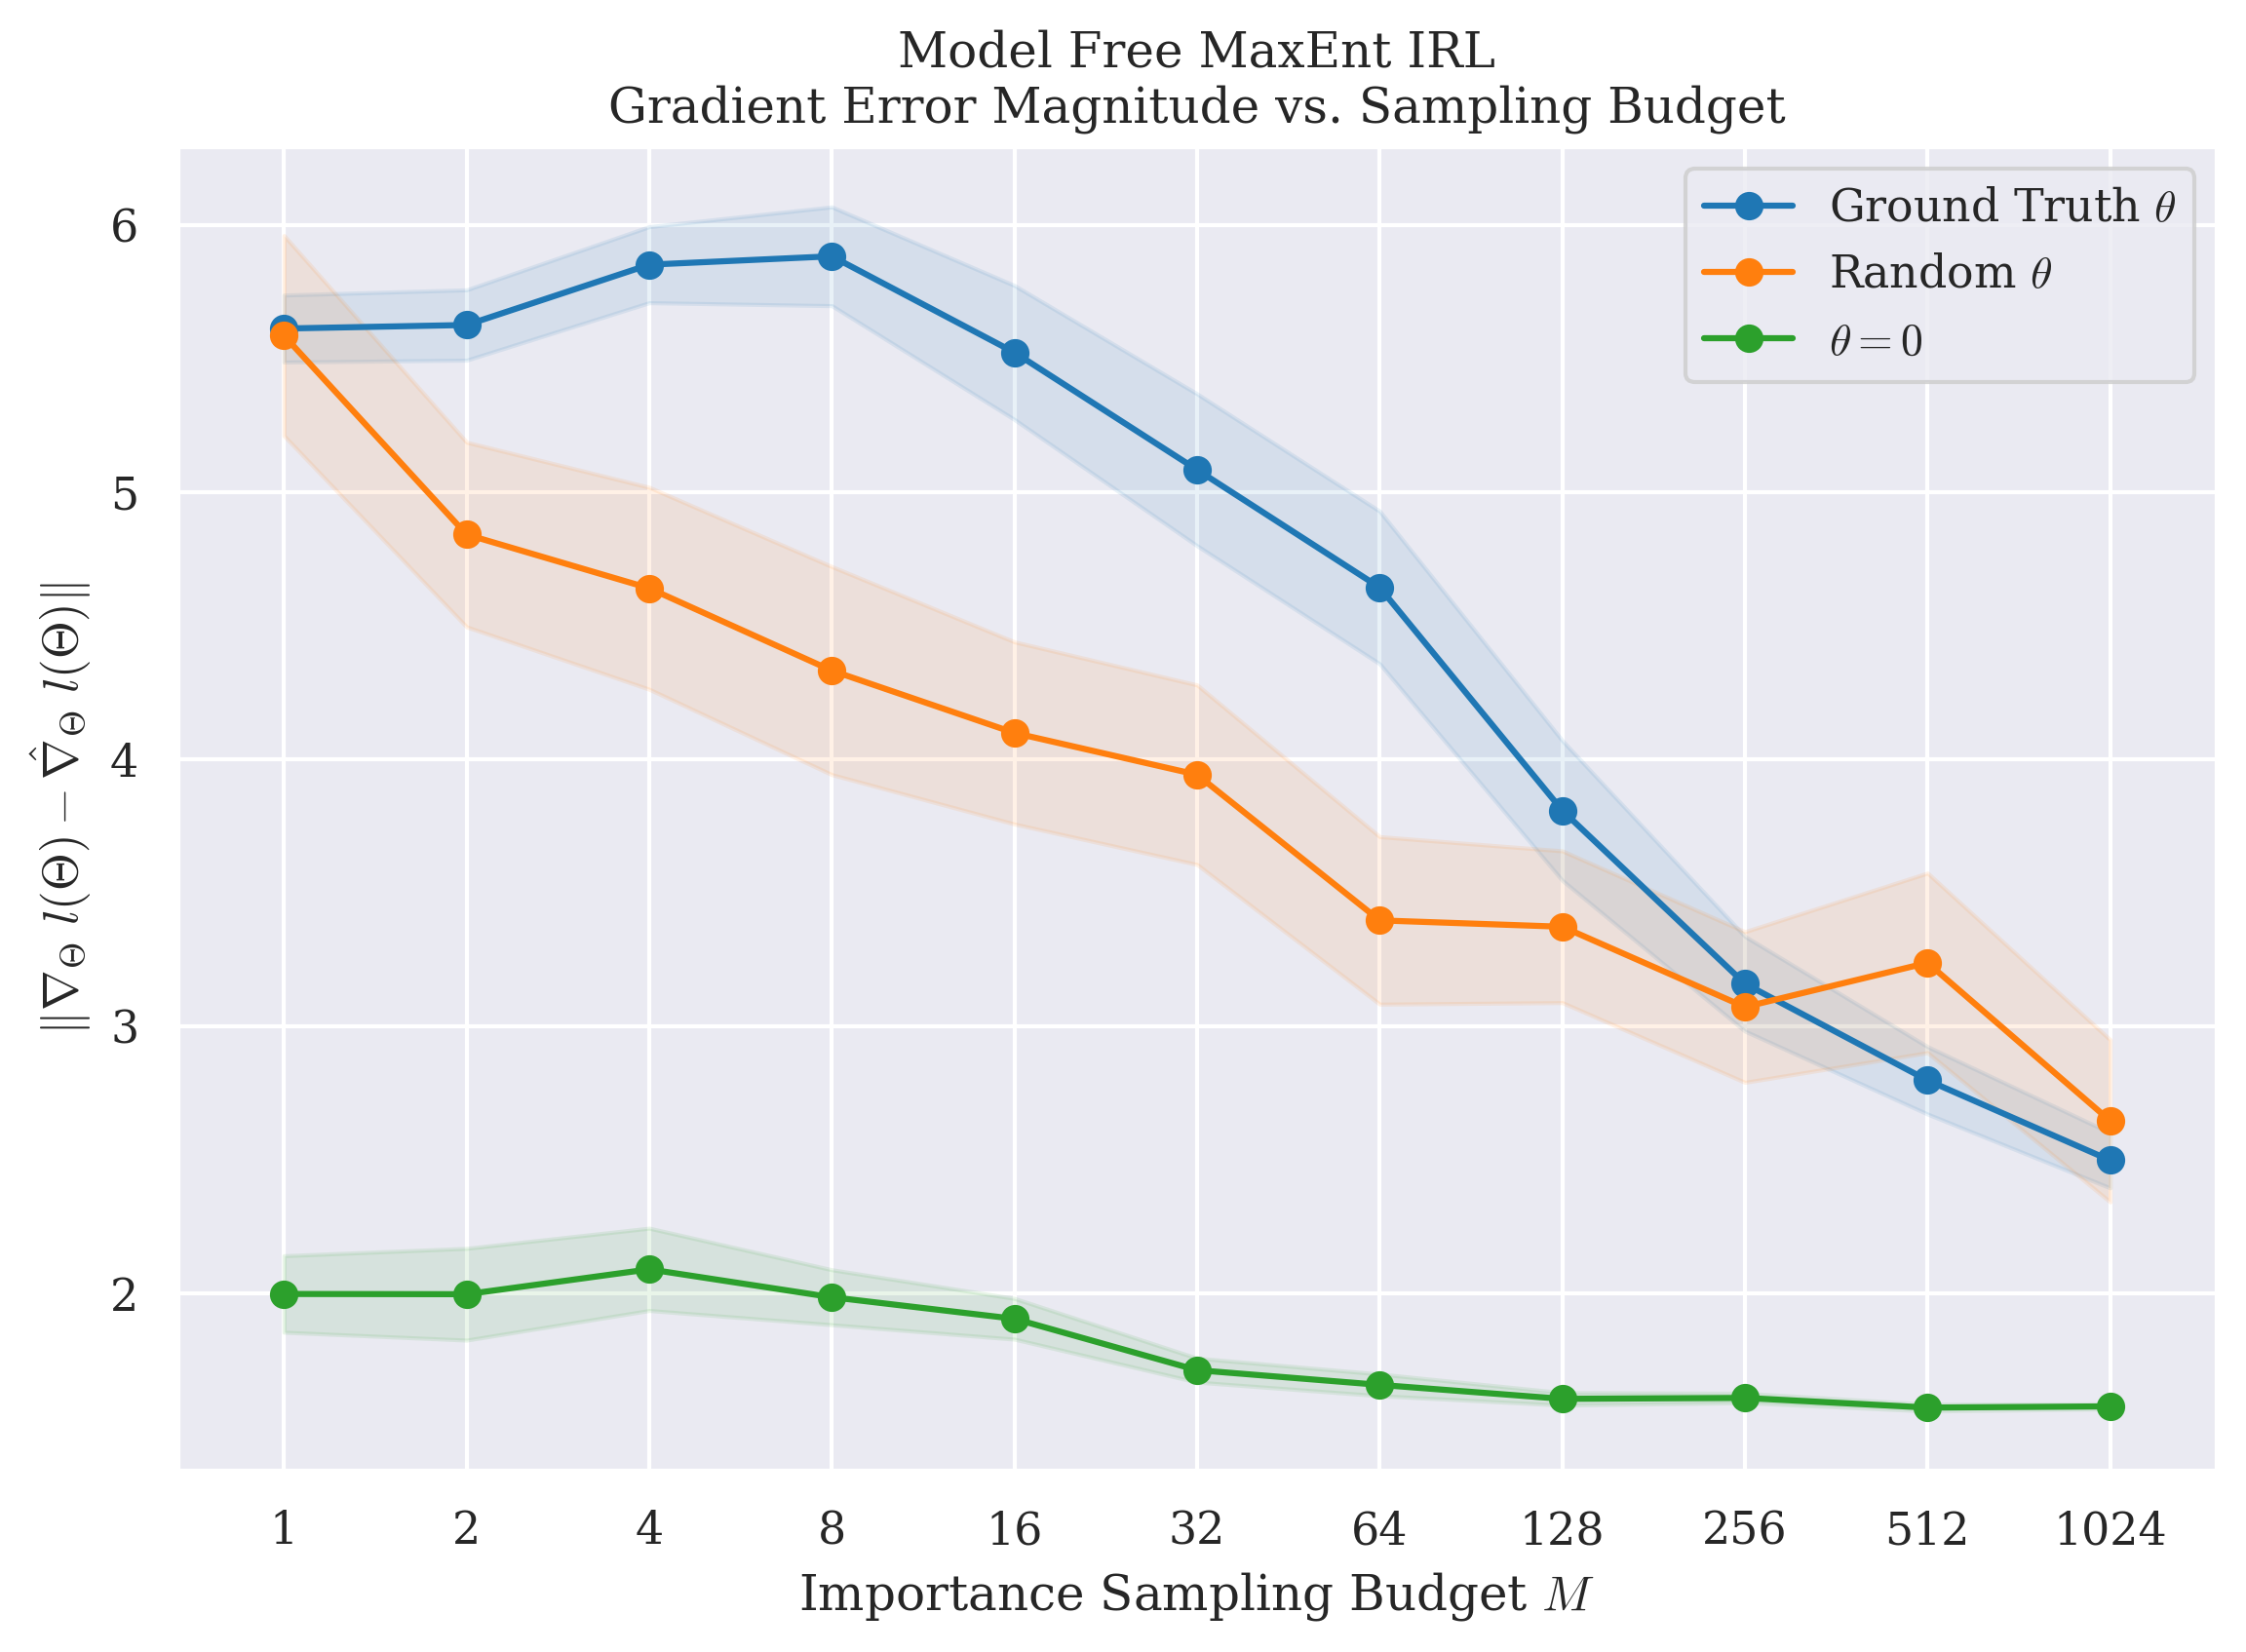

In [5]:

plt.figure(figsize=(9, 6), dpi=300)
sns.set()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams["mathtext.fontset"] = "cm"

def do_plt(col_name, color, label):
    means = []
    cis = []
    for m in m_vals:
        df_slice = df.query(f"`Theta Init` == '{col_name}' and M == {m}")
        _, mean, high = mean_ci(df_slice["Grad Error Mag"].to_numpy())
        means.append(mean)
        cis.append(high - mean)
    means = np.array(means)
    cis = np.array(cis)

    p1 = plt.plot(m_vals, means, 'o-', color=color, label=label)
    plt.fill_between(
        m_vals,
        means - cis,
        means + cis,
        color=p1[0].get_color(),
        alpha=0.1
    )

do_plt("Ground Truth", "tab:blue", r"Ground Truth $\theta$")
do_plt("Random", "tab:orange", r"Random $\theta$")
do_plt("Zero", "tab:green", r"$\theta = 0$")

plt.ylabel(r"$\| \nabla_\Theta ~l(\Theta) - \hat{\nabla}_\Theta ~l(\Theta) \|$")
plt.xlabel(r"Importance Sampling Budget $M$")

plt.semilogx(base=2)
plt.xticks(m_vals, m_vals)

plt.xlim(min(m_vals)/1.5, max(m_vals)*1.5)

plt.legend()

plt.savefig("fig-maxent-modelfree-grad-em.pdf", bbox_inches='tight', pad_inches=0)
plt.title("Model Free MaxEnt IRL\nGradient Error Magnitude vs. Sampling Budget")
plt.savefig("fig-maxent-modelfree-grad-em-withtitle.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

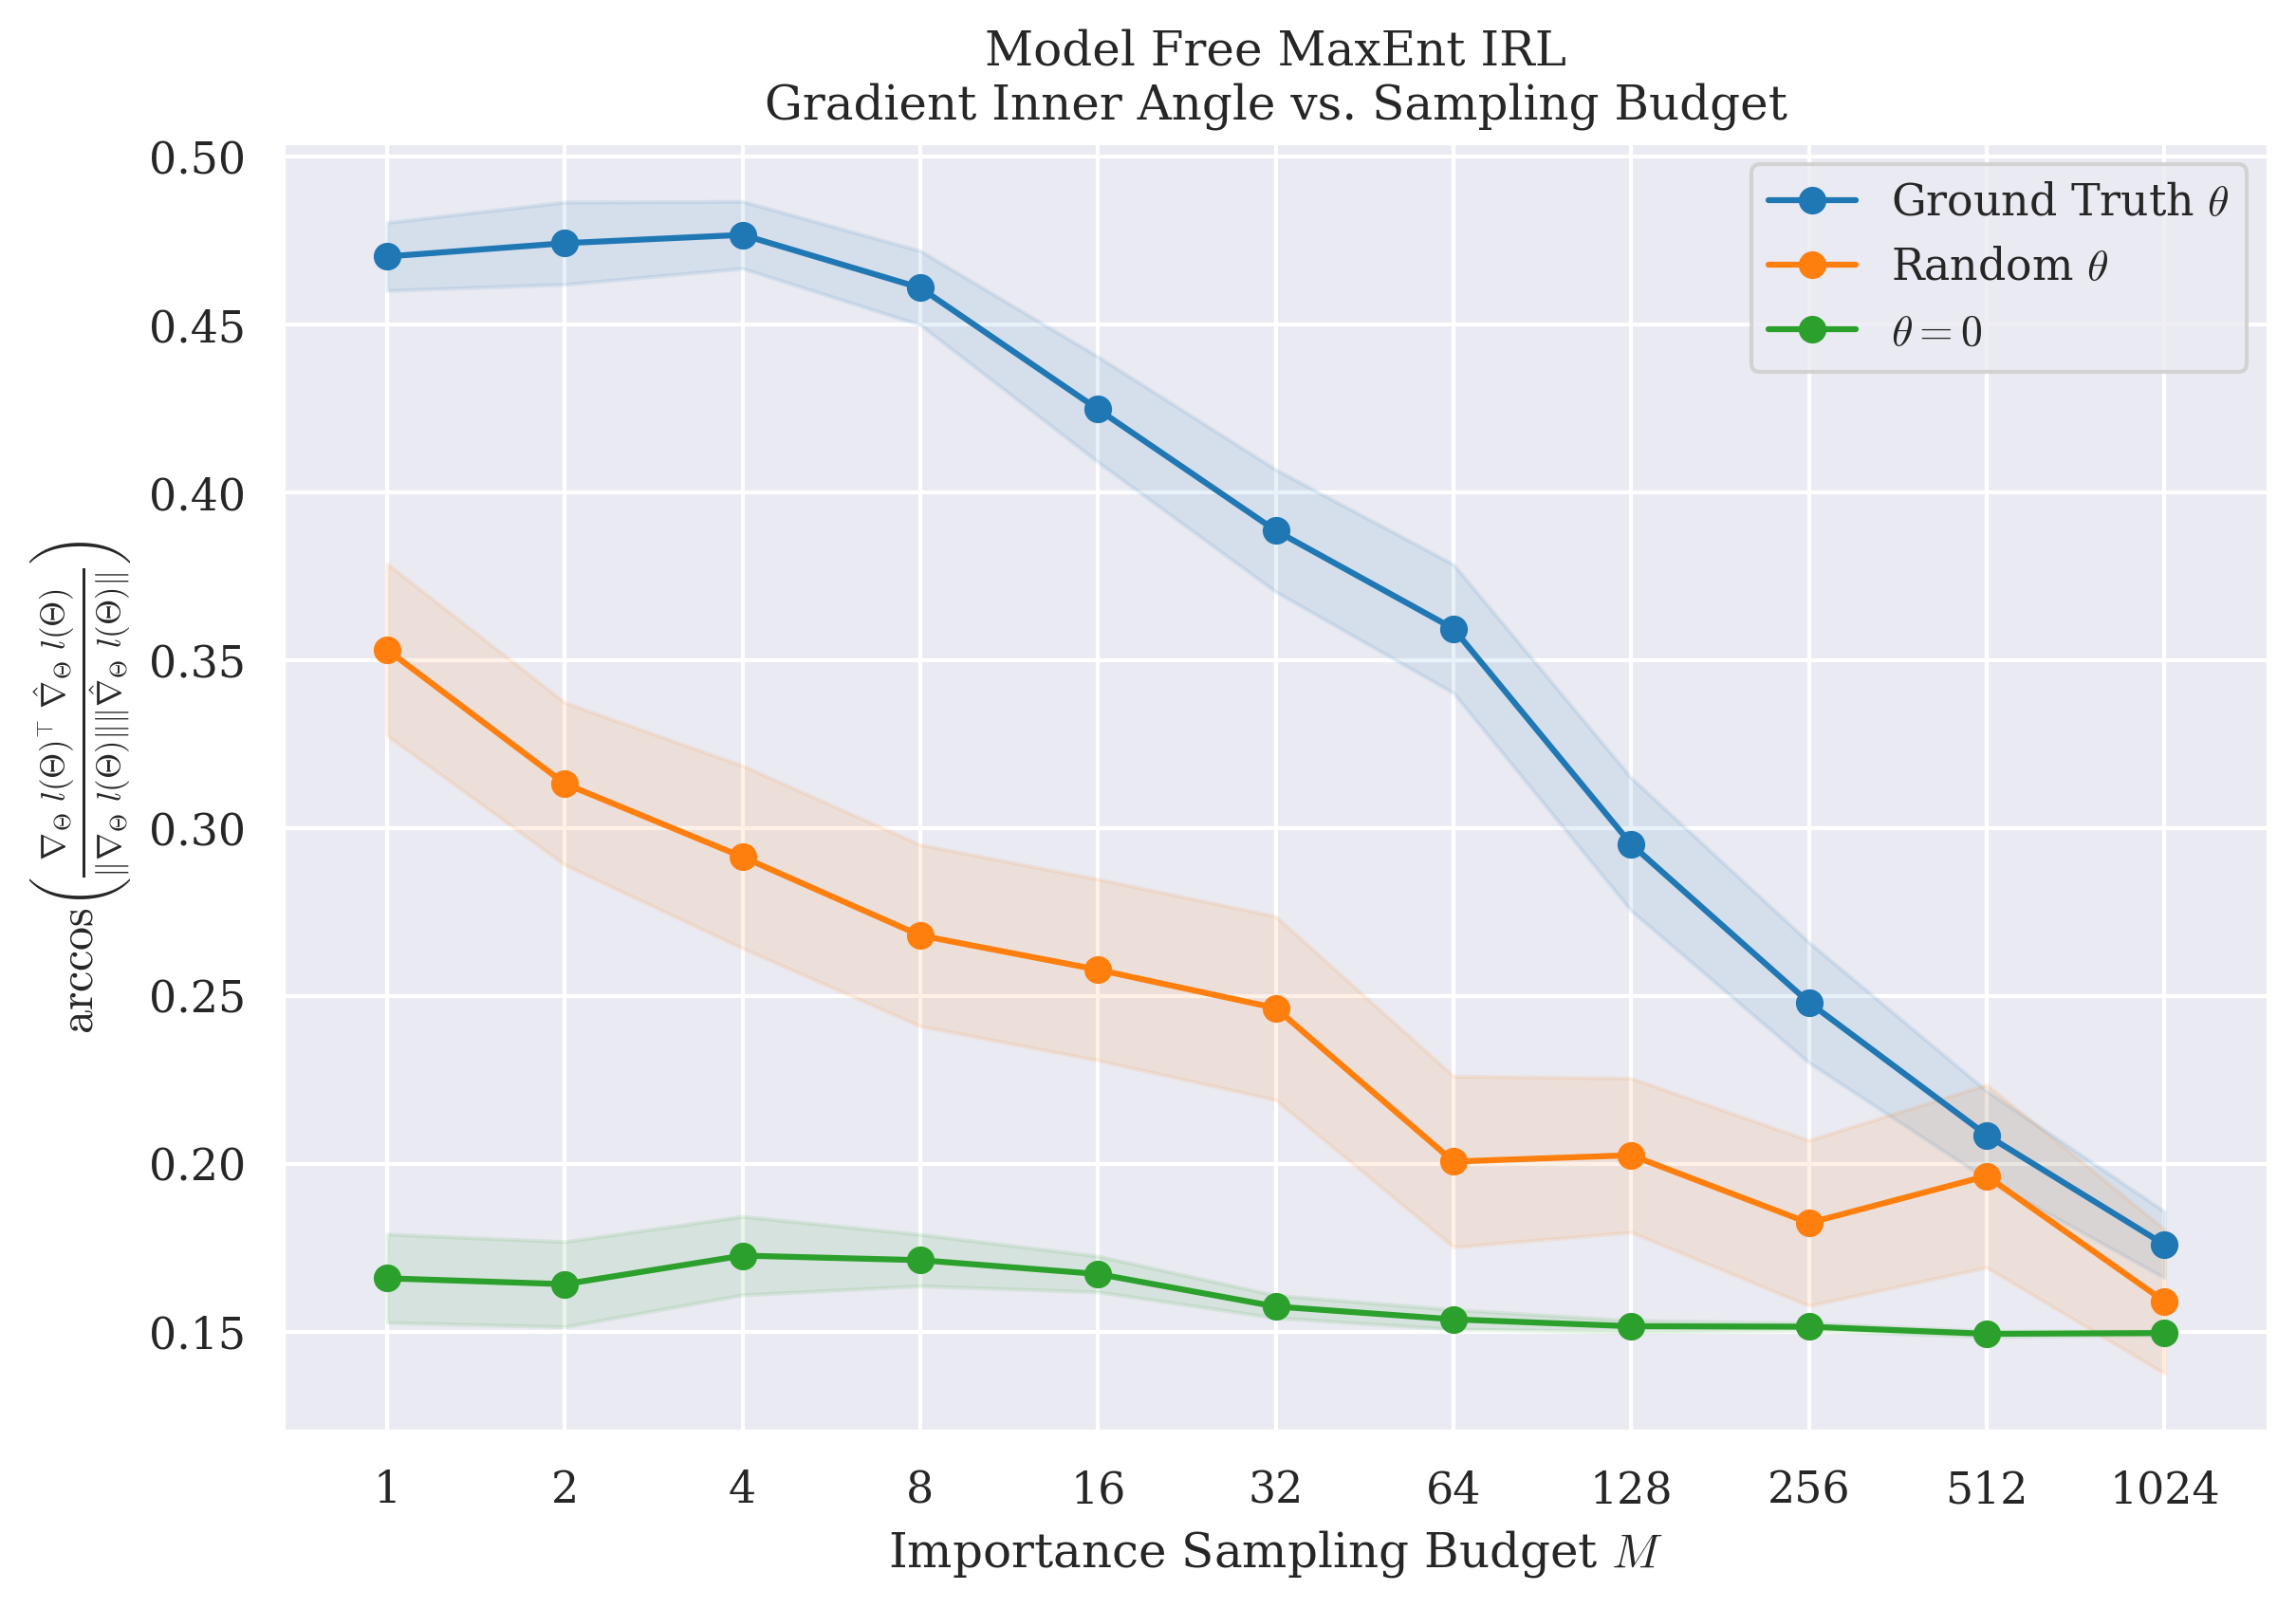

In [6]:

plt.figure(figsize=(9, 6), dpi=300)
sns.set()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams["mathtext.fontset"] = "cm"

def do_plt(col_name, color, label):
    means = []
    cis = []
    for m in m_vals:
        df_slice = df.query(f"`Theta Init` == '{col_name}' and M == {m}")
        _, mean, high = mean_ci(df_slice["Grad Inner Angle"].to_numpy())
        means.append(mean)
        cis.append(high - mean)
    means = np.array(means)
    cis = np.array(cis)

    p1 = plt.plot(m_vals, means, 'o-', color=color, label=label)
    plt.fill_between(
        m_vals,
        means - cis,
        means + cis,
        color=p1[0].get_color(),
        alpha=0.1
    )

do_plt("Ground Truth", "tab:blue", r"Ground Truth $\theta$")
do_plt("Random", "tab:orange", r"Random $\theta$")
do_plt("Zero", "tab:green", r"$\theta = 0$")

plt.ylabel(r"$\arccos\left( \frac{{\nabla_\Theta ~l(\Theta)}^\top ~\hat{\nabla}_\Theta ~l(\Theta)}{\|{\nabla_\Theta ~l(\Theta)}\| \|\hat{\nabla}_\Theta ~l(\Theta)\| } \right)$")
plt.xlabel(r"Importance Sampling Budget $M$")

plt.semilogx(base=2)
plt.xticks(m_vals, m_vals)

plt.xlim(min(m_vals)/1.5, max(m_vals)*1.5)

plt.legend()

plt.savefig("fig-maxent-modelfree-grad-ia.pdf", bbox_inches='tight', pad_inches=0)
plt.title("Model Free MaxEnt IRL\nGradient Inner Angle vs. Sampling Budget")
plt.savefig("fig-maxent-modelfree-grad-ia-withtitle.pdf", bbox_inches='tight', pad_inches=0)
plt.show()